In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
#from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import ParameterGrid
#from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, plot, plot_components,add_changepoints_to_plot

In [27]:
dataset = pd.read_csv("data.csv")

In [3]:
# change data type of ds column to pd.datatime as require of model Prophet
dataset['ds'] = pd.to_datetime(dataset['ds'])

# Splitting the data into train and test sets
train = dataset.iloc[:-4]  # Using all except the last 4 months for training
test = dataset.iloc[-4:]  # Using the last 4 months for testing

In [4]:
# using simple MAPE to find the best hyperparameter
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

### Parameters that can be tuned

**changepoint_prior_scale**: This is probably the most impactful parameter. It determines the flexibility of the trend, and in particular how much the trend changes at the trend changepoints. As described in this documentation, if it is too small, the trend will be underfit and variance that should have been modeled with trend changes will instead end up being handled with the noise term. If it is too large, the trend will overfit and in the most extreme case you can end up with the trend capturing yearly seasonality. The default of 0.05 works for many time series, but this could be tuned; a range of [0.001, 0.5] would likely be about right. Parameters like this (regularization penalties; this is effectively a lasso penalty) are often tuned on a log scale.

**seasonality_prior_scale**: This parameter controls the flexibility of the seasonality. Similarly, a large value allows the seasonality to fit large fluctuations, a small value shrinks the magnitude of the seasonality. The default is 10., which applies basically no regularization. That is because we very rarely see overfitting here (there’s inherent regularization with the fact that it is being modeled with a truncated Fourier series, so it’s essentially low-pass filtered). A reasonable range for tuning it would probably be [0.01, 10]; when set to 0.01 you should find that the magnitude of seasonality is forced to be very small. This likely also makes sense on a log scale, since it is effectively an L2 penalty like in ridge regression.

**holidays_prior_scale**: This controls flexibility to fit holiday effects. Similar to seasonality_prior_scale, it defaults to 10.0 which applies basically no regularization, since we usually have multiple observations of holidays and can do a good job of estimating their effects. This could also be tuned on a range of [0.01, 10] as with seasonality_prior_scale.

**seasonality_mode**: Options are ['additive', 'multiplicative']. Default is 'additive', but many business time series will have multiplicative seasonality. This is best identified just from looking at the time series and seeing if the magnitude of seasonal fluctuations grows with the magnitude of the time series (see the documentation here on multiplicative seasonality), but when that isn’t possible, it could be tuned.

In [5]:
# input hyperparameter want to try
params_grid = {'seasonality_mode':('multiplicative','additive'),
            'changepoint_prior_scale':[0.001, 0.002, 0.003, 0.004, 0.005,
                                        0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5],
            'seasonality_prior_scale':[0.01, 0.02, 0.03, 0.04, 0.05,
                                        0.1,0.2, 0.3, 0.4, 0.5,
                                        1.0, 2.0, 3.0, 4.0, 5.0, 10.0]}

# make parameters grid to test
grid = ParameterGrid(params_grid)

# trial numbers
cnt = 0
for p in grid:
    cnt = cnt+1
print('Total Possible Models',cnt)

Total Possible Models 480


In [14]:
# create initial DataFrame
model_parameters = pd.DataFrame(columns = ['MAPE','Parameters'])

#trial count
_try = 0

# try hyperparameters
for p in grid:
    train_forecast = pd.DataFrame()
    train_model =Prophet(changepoint_prior_scale = p['changepoint_prior_scale'],
                        seasonality_prior_scale = p['seasonality_prior_scale'],
                        seasonality_mode = p['seasonality_mode'])
    train_model.fit(train)
    train_forecast = train_model.make_future_dataframe(periods=12, freq='MS')
    train_forecast = train_model.predict(train_forecast)
    train_forecast = train_forecast[['ds','yhat']]
    train_forecast = train_forecast[35:39]
    train_test = test
    MAPE = mean_absolute_percentage_error(train_test['y'],abs(train_forecast['yhat']))
    _try +=1
    print('--------------------------------------------------------------------------------------------------')
    print('try', _try, '-- Mean Absolute Percentage Error(MAPE)------------------------------------',MAPE)
    try_parameter = pd.DataFrame({'MAPE':MAPE,'Parameters':[p]})
    model_parameters = pd.concat([model_parameters,try_parameter],ignore_index=True)

14:30:25 - cmdstanpy - INFO - Chain [1] start processing
14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 1 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.12752046190984


14:30:25 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 2 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.65425203362165


14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 3 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.876480426709247


14:30:26 - cmdstanpy - INFO - Chain [1] done processing
14:30:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 4 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.777804315400463


14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 5 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.487586836022295


14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 6 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.067715210343941


14:30:27 - cmdstanpy - INFO - Chain [1] done processing
14:30:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 7 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.34968702354997


14:30:30 - cmdstanpy - INFO - Chain [1] done processing
14:30:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 8 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.669026226600117


14:30:31 - cmdstanpy - INFO - Chain [1] done processing
14:30:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 9 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.533368270407829


14:30:32 - cmdstanpy - INFO - Chain [1] done processing
14:30:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 10 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.586077255612619


14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 11 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.961944564886082


14:30:33 - cmdstanpy - INFO - Chain [1] done processing
14:30:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 12 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.813158495877069


14:30:34 - cmdstanpy - INFO - Chain [1] done processing
14:30:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 13 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.320992780574283


14:30:37 - cmdstanpy - INFO - Chain [1] done processing
14:30:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 14 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.010072609153065


14:30:38 - cmdstanpy - INFO - Chain [1] done processing
14:30:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 15 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.060381069967695


14:30:39 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 16 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.85278553209764


14:30:39 - cmdstanpy - INFO - Chain [1] start processing
14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 17 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.685386243892992


14:30:39 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 18 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.828501501483238


14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 19 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.729751228484497


14:30:40 - cmdstanpy - INFO - Chain [1] done processing
14:30:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 20 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.490543507415046


14:30:41 - cmdstanpy - INFO - Chain [1] done processing
14:30:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 21 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.582893361724159


14:30:42 - cmdstanpy - INFO - Chain [1] done processing
14:30:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 22 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.015566799827639


14:30:43 - cmdstanpy - INFO - Chain [1] done processing
14:30:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 23 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.532605864060214


14:30:43 - cmdstanpy - INFO - Chain [1] done processing
14:30:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 24 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.5192167987210885


14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 25 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.62820687505953


14:30:44 - cmdstanpy - INFO - Chain [1] done processing
14:30:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 26 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.217472799604174


14:30:45 - cmdstanpy - INFO - Chain [1] done processing
14:30:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 27 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.27118852241849


14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 28 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.52986645714915


14:30:46 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 29 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.251545429882704


14:30:47 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 30 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.806617416251939


14:30:47 - cmdstanpy - INFO - Chain [1] done processing
14:30:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 31 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.62118793093525


14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 32 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.806490594107622


14:30:48 - cmdstanpy - INFO - Chain [1] done processing
14:30:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 33 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.57359459311558


14:30:49 - cmdstanpy - INFO - Chain [1] done processing
14:30:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 34 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.553692217996705


14:30:50 - cmdstanpy - INFO - Chain [1] done processing
14:30:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 35 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.79951772284067


14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 36 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.756830172668113


14:30:51 - cmdstanpy - INFO - Chain [1] done processing
14:30:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 37 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.417993956883866


14:30:52 - cmdstanpy - INFO - Chain [1] done processing
14:30:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 38 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.254691081617185


14:30:52 - cmdstanpy - INFO - Chain [1] done processing
14:30:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 39 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.747040616977163


14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 40 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.25877289481251


14:30:53 - cmdstanpy - INFO - Chain [1] done processing
14:30:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 41 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.987950325835298


14:30:54 - cmdstanpy - INFO - Chain [1] done processing
14:30:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 42 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.945995816287763


14:30:54 - cmdstanpy - INFO - Chain [1] done processing
14:30:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 43 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.884207003244985


14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 44 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.73309038012602


14:30:55 - cmdstanpy - INFO - Chain [1] done processing
14:30:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 45 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.379541868910524


14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 46 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.235053814199834


14:30:56 - cmdstanpy - INFO - Chain [1] done processing
14:30:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 47 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.446537980506708


14:30:57 - cmdstanpy - INFO - Chain [1] done processing
14:30:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 48 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.871896838992683


14:30:57 - cmdstanpy - INFO - Chain [1] done processing
14:30:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 49 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.381445255007485


14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 50 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.798689347477005


14:30:58 - cmdstanpy - INFO - Chain [1] done processing
14:30:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 51 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.729807099655863


14:30:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 52 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.569752178609647


14:30:59 - cmdstanpy - INFO - Chain [1] done processing
14:30:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 53 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.30798688142293


14:31:00 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 54 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.133675272621097


14:31:01 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 55 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.580229198456443


14:31:01 - cmdstanpy - INFO - Chain [1] done processing
14:31:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 56 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.521520035048976


14:31:01 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 57 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6348639999978305


14:31:02 - cmdstanpy - INFO - Chain [1] done processing
14:31:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 58 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.200166083068595


14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 59 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.499014546057131


14:31:03 - cmdstanpy - INFO - Chain [1] done processing
14:31:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 60 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.410016415947593


14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 61 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.200601750137313


14:31:04 - cmdstanpy - INFO - Chain [1] done processing
14:31:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 62 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.896394362551671


14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 63 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.78933925321705


14:31:05 - cmdstanpy - INFO - Chain [1] done processing
14:31:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 64 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.809112050810732


14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 65 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.54203091089497


14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 66 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.43629483873194


14:31:06 - cmdstanpy - INFO - Chain [1] done processing
14:31:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 67 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.262629776640846


14:31:07 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 68 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.600885777718997


14:31:07 - cmdstanpy - INFO - Chain [1] start processing
14:31:07 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 69 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.317877473861078


14:31:08 - cmdstanpy - INFO - Chain [1] done processing
14:31:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 70 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.24656032708345


14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 71 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.727307440009072


14:31:09 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 72 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.74087430507091


14:31:09 - cmdstanpy - INFO - Chain [1] start processing
14:31:09 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 73 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.640282671881428


14:31:10 - cmdstanpy - INFO - Chain [1] done processing
14:31:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 74 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.674827749385539


14:31:11 - cmdstanpy - INFO - Chain [1] done processing
14:31:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 75 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.621622762760659


14:31:11 - cmdstanpy - INFO - Chain [1] done processing
14:31:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 76 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.541454942869816


14:31:11 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 77 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.469438217220048


14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 78 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.55429739616337


14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 79 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.486080974587907


14:31:12 - cmdstanpy - INFO - Chain [1] done processing
14:31:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 80 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.876765847319724


14:31:13 - cmdstanpy - INFO - Chain [1] done processing
14:31:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 81 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.246999239576628


14:31:13 - cmdstanpy - INFO - Chain [1] done processing
14:31:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 82 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.776355502723383


14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 83 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.971168232385487


14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 84 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.083659364425259


14:31:14 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 85 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.639037439524794


14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 86 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.897713717512107


14:31:15 - cmdstanpy - INFO - Chain [1] done processing
14:31:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 87 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.580124644058432


14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 88 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.528473079089379


14:31:16 - cmdstanpy - INFO - Chain [1] done processing
14:31:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 89 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.624809620251885


14:31:17 - cmdstanpy - INFO - Chain [1] done processing
14:31:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 90 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.146582123249257


14:31:18 - cmdstanpy - INFO - Chain [1] done processing
14:31:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 91 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.426757919022293


14:31:19 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 92 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.43124507123581


14:31:19 - cmdstanpy - INFO - Chain [1] start processing
14:31:20 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 93 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.585930272473197


14:31:20 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 94 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.849380257487457


14:31:21 - cmdstanpy - INFO - Chain [1] start processing
14:31:21 - cmdstanpy - INFO - Chain [1] done processing
14:31:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 95 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.683544563582192


14:31:22 - cmdstanpy - INFO - Chain [1] done processing
14:31:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 96 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.820951371722558


14:31:22 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 97 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.561103185956974


14:31:23 - cmdstanpy - INFO - Chain [1] start processing
14:31:23 - cmdstanpy - INFO - Chain [1] done processing
14:31:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 98 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.136389623921865


14:31:24 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 99 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.33776015246794


14:31:24 - cmdstanpy - INFO - Chain [1] start processing
14:31:24 - cmdstanpy - INFO - Chain [1] done processing
14:31:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 100 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.613599219724026


14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 101 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.299596286581647


14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 102 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.226540393855652


14:31:25 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 103 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.915708398065316


14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 104 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.646993082391823


14:31:26 - cmdstanpy - INFO - Chain [1] done processing
14:31:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 105 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.707160546406875


14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 106 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.674371935274433


14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 107 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.079596586956091


14:31:27 - cmdstanpy - INFO - Chain [1] done processing
14:31:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 108 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.493932778675902


14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 109 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.464415661259789


14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 110 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.552900618073721


14:31:28 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 111 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.484583876291182


14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 112 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.896810107938805


14:31:29 - cmdstanpy - INFO - Chain [1] done processing
14:31:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 113 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.27190594354179


14:31:30 - cmdstanpy - INFO - Chain [1] done processing
14:31:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 114 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.773485537601495


14:31:30 - cmdstanpy - INFO - Chain [1] done processing
14:31:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 115 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.966040258566197


14:31:30 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 116 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.087790884025782


14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 117 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.612642888485464


14:31:31 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 118 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.898495786386888


14:31:32 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 119 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.582968277520812


14:31:32 - cmdstanpy - INFO - Chain [1] done processing
14:31:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 120 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.52551861298273


14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 121 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.641074302535202


14:31:33 - cmdstanpy - INFO - Chain [1] done processing
14:31:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 122 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.166533495453443


14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 123 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.669265746117055


14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 124 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.268087770617521


14:31:34 - cmdstanpy - INFO - Chain [1] done processing
14:31:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 125 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.591110282123463


14:31:35 - cmdstanpy - INFO - Chain [1] done processing
14:31:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 126 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.913149768938503


14:31:35 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 127 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.643957566242918


14:31:36 - cmdstanpy - INFO - Chain [1] done processing
14:31:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 128 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.818581214894554


14:31:36 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 129 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.551478875113148


14:31:37 - cmdstanpy - INFO - Chain [1] start processing
14:31:37 - cmdstanpy - INFO - Chain [1] done processing
14:31:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 130 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.98901944851995


14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 131 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.425960502827394


14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 132 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.62522258314795


14:31:38 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 133 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.311774166448508


14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 134 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.23763882740864


14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 135 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.898748069119126


14:31:39 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 136 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.64708207501377


14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 137 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.701049686200498


14:31:40 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 138 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.668814744759176


14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 139 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.08031257920062


14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 140 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.494538052966732


14:31:41 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 141 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.464874292486014


14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 142 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.552018620804835


14:31:42 - cmdstanpy - INFO - Chain [1] done processing
14:31:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 143 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.48209088096469


14:31:43 - cmdstanpy - INFO - Chain [1] done processing
14:31:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 144 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.886532735728053


14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 145 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.91707746022188


14:31:44 - cmdstanpy - INFO - Chain [1] done processing
14:31:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 146 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.735440344224916


14:31:44 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 147 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.945859055545423


14:31:45 - cmdstanpy - INFO - Chain [1] start processing
14:31:45 - cmdstanpy - INFO - Chain [1] done processing
14:31:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 148 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.088295812672929


14:31:45 - cmdstanpy - INFO - Chain [1] done processing
14:31:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 149 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.653592834938655


14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 150 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.081217390183781


14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 151 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.584500466087074


14:31:46 - cmdstanpy - INFO - Chain [1] done processing
14:31:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 152 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.652792723465359


14:31:47 - cmdstanpy - INFO - Chain [1] done processing
14:31:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 153 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.635414805034946


14:31:47 - cmdstanpy - INFO - Chain [1] done processing
14:31:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 154 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.08733408727447


14:31:47 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 155 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.665130725047478


14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 156 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.281804702724472


14:31:48 - cmdstanpy - INFO - Chain [1] done processing
14:31:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 157 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.55230462037725


14:31:49 - cmdstanpy - INFO - Chain [1] done processing
14:31:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 158 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.384365141134225


14:31:49 - cmdstanpy - INFO - Chain [1] done processing
14:31:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 159 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.82399258814594


14:31:49 - cmdstanpy - INFO - Chain [1] done processing
14:31:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 160 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.854817365595302


14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 161 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.17272225961176


14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 162 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.59760022205987


14:31:50 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 163 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.74858429375631


14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 164 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.144257598306883


14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 165 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.797041362639185


14:31:51 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 166 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.179706315448945


14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 167 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.864881733231725


14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 168 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.64728604661104


14:31:52 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 169 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.691061739623612


14:31:53 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 170 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.66309275432564


14:31:53 - cmdstanpy - INFO - Chain [1] done processing
14:31:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 171 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.06089974990127


14:31:53 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 172 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.501724553743937


14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 173 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.432788055132793


14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 174 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.536923288804543


14:31:54 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 175 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.46826862873885


14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 176 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.982562100498377


14:31:55 - cmdstanpy - INFO - Chain [1] done processing
14:31:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 177 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.859943920956898


14:31:56 - cmdstanpy - INFO - Chain [1] done processing
14:31:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 178 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.513224237282394


14:31:56 - cmdstanpy - INFO - Chain [1] done processing
14:31:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 179 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.71719583474637


14:31:56 - cmdstanpy - INFO - Chain [1] done processing
14:31:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 180 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.05854492672555


14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 181 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.107678846429664


14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 182 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.329263574124484


14:31:57 - cmdstanpy - INFO - Chain [1] done processing
14:31:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 183 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.616343160794534


14:31:58 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 184 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6621767395256155


14:31:58 - cmdstanpy - INFO - Chain [1] start processing
14:31:59 - cmdstanpy - INFO - Chain [1] done processing
14:31:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 185 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.7175675193229685


14:31:59 - cmdstanpy - INFO - Chain [1] done processing
14:31:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 186 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.977195726431676


14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 187 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.767366822848317


14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 188 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.262540593814432


14:32:00 - cmdstanpy - INFO - Chain [1] done processing
14:32:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 189 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.556458064370371


14:32:01 - cmdstanpy - INFO - Chain [1] done processing
14:32:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 190 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.512853676270428


14:32:01 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 191 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.428175856566913


14:32:02 - cmdstanpy - INFO - Chain [1] start processing
14:32:02 - cmdstanpy - INFO - Chain [1] done processing
14:32:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 192 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.8399857405944


14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 193 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.38808038032044


14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 194 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.846092537613497


14:32:03 - cmdstanpy - INFO - Chain [1] done processing
14:32:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 195 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.895444945236918


14:32:04 - cmdstanpy - INFO - Chain [1] done processing
14:32:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 196 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.182423235154015


14:32:04 - cmdstanpy - INFO - Chain [1] done processing
14:32:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 197 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.790966449912062


14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 198 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.066946057309844


14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 199 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.723284456758124


14:32:05 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 200 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.647246261862552


14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 201 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.643956331419975


14:32:06 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 202 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.666499254681263


14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 203 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.066076291819348


14:32:07 - cmdstanpy - INFO - Chain [1] done processing
14:32:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 204 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.524480047626264


14:32:08 - cmdstanpy - INFO - Chain [1] done processing
14:32:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 205 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.47483082960008


14:32:08 - cmdstanpy - INFO - Chain [1] done processing
14:32:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 206 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.536784027188055


14:32:08 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 207 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.408336981627862


14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 208 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.905636202227747


14:32:09 - cmdstanpy - INFO - Chain [1] done processing
14:32:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 209 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.852735741247336


14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 210 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.458749072698076


14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 211 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.685846443231515


14:32:10 - cmdstanpy - INFO - Chain [1] done processing
14:32:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 212 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.181219991859768


14:32:11 - cmdstanpy - INFO - Chain [1] done processing
14:32:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 213 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.120698774652652


14:32:11 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 214 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.33642032761068


14:32:12 - cmdstanpy - INFO - Chain [1] start processing
14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 215 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.609382362436285


14:32:12 - cmdstanpy - INFO - Chain [1] done processing
14:32:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 216 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.588606062646846


14:32:13 - cmdstanpy - INFO - Chain [1] done processing
14:32:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 217 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.721167763272876


14:32:13 - cmdstanpy - INFO - Chain [1] done processing
14:32:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 218 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.000216925456415


14:32:13 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 219 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.83088464314198


14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 220 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.227616929407056


14:32:14 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 221 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.541026455966255


14:32:15 - cmdstanpy - INFO - Chain [1] done processing
14:32:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 222 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.245416278880647


14:32:16 - cmdstanpy - INFO - Chain [1] done processing
14:32:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 223 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.51464131082976


14:32:16 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 224 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.85880869065437


14:32:16 - cmdstanpy - INFO - Chain [1] start processing
14:32:16 - cmdstanpy - INFO - Chain [1] done processing
14:32:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 225 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.5877463796896


14:32:17 - cmdstanpy - INFO - Chain [1] done processing
14:32:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 226 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.176231451622247


14:32:17 - cmdstanpy - INFO - Chain [1] done processing
14:32:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 227 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.370201246949865


14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 228 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.18687544967975


14:32:18 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 229 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.77350338921439


14:32:18 - cmdstanpy - INFO - Chain [1] start processing
14:32:18 - cmdstanpy - INFO - Chain [1] done processing
14:32:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 230 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.032368861245212


14:32:19 - cmdstanpy - INFO - Chain [1] done processing
14:32:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 231 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.697900908089437


14:32:19 - cmdstanpy - INFO - Chain [1] done processing
14:32:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 232 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.647667672619978


14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 233 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.658296625268155


14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 234 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.670028450640324


14:32:20 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 235 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.038186508484772


14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 236 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.568844641730221


14:32:21 - cmdstanpy - INFO - Chain [1] done processing
14:32:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 237 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.477164862920697


14:32:22 - cmdstanpy - INFO - Chain [1] done processing
14:32:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 238 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.536922671136022


14:32:22 - cmdstanpy - INFO - Chain [1] done processing
14:32:22 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 239 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.479838969701554


14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 240 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.90936679499732


14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 241 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.399443226466044


14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 242 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.454641939724482


14:32:23 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 243 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.598256931315646


14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 244 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.983928163330614


14:32:24 - cmdstanpy - INFO - Chain [1] done processing
14:32:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 245 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.13115723617078


14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 246 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.343762807627918


14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 247 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.654528054507612


14:32:25 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 248 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.638964952182689


14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 249 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.681969414622057


14:32:26 - cmdstanpy - INFO - Chain [1] done processing
14:32:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 250 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.98953938512258


14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 251 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.841397585013796


14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 252 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.24735256983376


14:32:27 - cmdstanpy - INFO - Chain [1] done processing
14:32:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 253 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.542629321348375


14:32:28 - cmdstanpy - INFO - Chain [1] done processing
14:32:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 254 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.135835346783477


14:32:28 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 255 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.448650606535168


14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 256 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.85867200192511


14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 257 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.813409301266113


14:32:29 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 258 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.30755733572813


14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 259 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.404643127050164


14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 260 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.358220076498316


14:32:30 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 261 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.021017105256732


14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 262 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.044073906953798


14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 263 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.731398226661785


14:32:31 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 264 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.657897840061018


14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 265 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.650266198689968


14:32:32 - cmdstanpy - INFO - Chain [1] done processing
14:32:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 266 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.657537261437785


14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 267 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.060580421656683


14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 268 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.546334097103898


14:32:33 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 269 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.473848894305828


14:32:34 - cmdstanpy - INFO - Chain [1] done processing
14:32:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 270 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.538834057174416


14:32:34 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 271 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.50223425393373


14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 272 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.897897217855487


14:32:35 - cmdstanpy - INFO - Chain [1] done processing
14:32:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 273 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.435003039139847


14:32:36 - cmdstanpy - INFO - Chain [1] done processing
14:32:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 274 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.50849072432357


14:32:36 - cmdstanpy - INFO - Chain [1] done processing
14:32:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 275 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.670348901559409


14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 276 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.065869508211561


14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 277 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.123355229240094


14:32:37 - cmdstanpy - INFO - Chain [1] done processing
14:32:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 278 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.36028684626999


14:32:38 - cmdstanpy - INFO - Chain [1] done processing
14:32:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 279 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.616789091421403


14:32:38 - cmdstanpy - INFO - Chain [1] done processing
14:32:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 280 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.6026165489295305


14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 281 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.729883619111387


14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 282 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.967272910583858


14:32:39 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 283 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.840094977549983


14:32:40 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 284 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.245119888915397


14:32:40 - cmdstanpy - INFO - Chain [1] done processing
14:32:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 285 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.557245240836409


14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 286 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.141639543374005


14:32:41 - cmdstanpy - INFO - Chain [1] done processing
14:32:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 287 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.431427630949752


14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 288 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.859998730733196


14:32:42 - cmdstanpy - INFO - Chain [1] done processing
14:32:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 289 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.7168233575286


14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 290 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.29789985180342


14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 291 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.3790889990467


14:32:43 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 292 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.14157600430358


14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 293 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.7816538259816


14:32:44 - cmdstanpy - INFO - Chain [1] done processing
14:32:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 294 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.035062722159177


14:32:45 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 295 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.71312207939114


14:32:45 - cmdstanpy - INFO - Chain [1] start processing
14:32:45 - cmdstanpy - INFO - Chain [1] done processing
14:32:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 296 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.673531655405556


14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 297 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.641184258691691


14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 298 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.667301225817988


14:32:46 - cmdstanpy - INFO - Chain [1] done processing
14:32:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 299 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.052474420969086


14:32:47 - cmdstanpy - INFO - Chain [1] done processing
14:32:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 300 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.537516300551593


14:32:47 - cmdstanpy - INFO - Chain [1] done processing
14:32:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 301 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.469158871841662


14:32:48 - cmdstanpy - INFO - Chain [1] done processing
14:32:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 302 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.537844173519666


14:32:48 - cmdstanpy - INFO - Chain [1] done processing
14:32:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 303 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.49234033409145


14:32:48 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 304 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.89911440432023


14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 305 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.406500290735135


14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 306 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.46103157933236


14:32:49 - cmdstanpy - INFO - Chain [1] done processing
14:32:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 307 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.658969990461474


14:32:50 - cmdstanpy - INFO - Chain [1] done processing
14:32:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 308 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.976262642396035


14:32:50 - cmdstanpy - INFO - Chain [1] done processing
14:32:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 309 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.109966479714155


14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 310 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.3462099140728


14:32:51 - cmdstanpy - INFO - Chain [1] done processing
14:32:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 311 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.56125116407403


14:32:52 - cmdstanpy - INFO - Chain [1] done processing
14:32:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 312 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.59432295678778


14:32:52 - cmdstanpy - INFO - Chain [1] done processing
14:32:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 313 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.70789108759519


14:32:52 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 314 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.9795437615398


14:32:53 - cmdstanpy - INFO - Chain [1] done processing
14:32:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 315 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.83852436340196


14:32:54 - cmdstanpy - INFO - Chain [1] done processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 316 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.27213521824886


14:32:54 - cmdstanpy - INFO - Chain [1] done processing
14:32:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 317 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.55752353686159


14:32:55 - cmdstanpy - INFO - Chain [1] done processing
14:32:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 318 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.13071976584111


14:32:55 - cmdstanpy - INFO - Chain [1] done processing
14:32:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 319 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.430417993105234


14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 320 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.865741038847865


14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 321 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.817711508969793


14:32:56 - cmdstanpy - INFO - Chain [1] done processing
14:32:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 322 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.292618443406596


14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:32:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 323 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.377410940426522


14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:32:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 324 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.221327530675687


14:32:57 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 325 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.80512581180661


14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 326 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.027437143665706


14:32:58 - cmdstanpy - INFO - Chain [1] done processing
14:32:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 327 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.715155549319459


14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 328 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.661210824101328


14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 329 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.653789383191937


14:32:59 - cmdstanpy - INFO - Chain [1] done processing
14:32:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 330 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.671915360135111


14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 331 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.06669009292923


14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 332 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.554997722499262


14:33:00 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 333 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.489917575875811


14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 334 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.573486496153349


14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 335 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.52695273519552


14:33:01 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 336 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.061587652087947


14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 337 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.39304423255988


14:33:02 - cmdstanpy - INFO - Chain [1] done processing
14:33:02 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 338 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 18.45452652422411


14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 339 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 15.565022311898552


14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:03 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 340 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.994595938219645


14:33:03 - cmdstanpy - INFO - Chain [1] done processing
14:33:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 341 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.007857267891557


14:33:04 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 342 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 7.850885815655772


14:33:04 - cmdstanpy - INFO - Chain [1] start processing
14:33:04 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 343 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.922285221085563


14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 344 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.554588596023068


14:33:05 - cmdstanpy - INFO - Chain [1] done processing
14:33:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 345 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.2260918481786


14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 346 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.671549082350339


14:33:06 - cmdstanpy - INFO - Chain [1] done processing
14:33:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 347 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.05410529079006


14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 348 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.63096182605765


14:33:07 - cmdstanpy - INFO - Chain [1] done processing
14:33:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 349 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.06921932294069


14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 350 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.541290333221724


14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 351 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.2111117166039


14:33:08 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 352 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.361438121882195


14:33:09 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 353 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.878841783820095


14:33:09 - cmdstanpy - INFO - Chain [1] done processing
14:33:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 354 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.463357570868572


14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 355 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.632144898291953


14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 356 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.653777924087288


14:33:10 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 357 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.35049561754508


14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 358 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.933466253482678


14:33:11 - cmdstanpy - INFO - Chain [1] done processing
14:33:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 359 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.176804864737473


14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 360 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 25.745802611595913


14:33:12 - cmdstanpy - INFO - Chain [1] done processing
14:33:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 361 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.910546579617474


14:33:13 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 362 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.642963591839337


14:33:13 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 363 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 33.79826545237103


14:33:13 - cmdstanpy - INFO - Chain [1] done processing
14:33:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 364 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.66053620678751


14:33:14 - cmdstanpy - INFO - Chain [1] done processing
14:33:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 365 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 98.73180686084082


14:33:14 - cmdstanpy - INFO - Chain [1] done processing
14:33:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 366 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 175.88734851131574


14:33:15 - cmdstanpy - INFO - Chain [1] done processing
14:33:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 367 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 110.85043254841986


14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 368 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 229.4398631720942


14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 369 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.140181110161416


14:33:16 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 370 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.226275548414138


14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 371 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 8.709777012924782


14:33:17 - cmdstanpy - INFO - Chain [1] done processing
14:33:17 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 372 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.689662935671377


14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 373 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.90124280221095


14:33:18 - cmdstanpy - INFO - Chain [1] done processing
14:33:18 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 374 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.481295099280336


14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 375 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.813416274333113


14:33:19 - cmdstanpy - INFO - Chain [1] done processing
14:33:19 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 376 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.85877516204069


14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 377 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.68889625775242


14:33:20 - cmdstanpy - INFO - Chain [1] done processing
14:33:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 378 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.833526257695326


14:33:21 - cmdstanpy - INFO - Chain [1] done processing
14:33:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 379 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.71957556821786


14:33:21 - cmdstanpy - INFO - Chain [1] done processing
14:33:21 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 380 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.25969273295105


14:33:23 - cmdstanpy - INFO - Chain [1] done processing
14:33:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 381 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.93304802090582


14:33:23 - cmdstanpy - INFO - Chain [1] done processing
14:33:23 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 382 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.980850031078525


14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 383 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.70198850322475


14:33:24 - cmdstanpy - INFO - Chain [1] done processing
14:33:24 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 384 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.3935112921093


14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 385 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.542706751877075


14:33:25 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 386 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.152490140469814


14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 387 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.44471154974882


14:33:26 - cmdstanpy - INFO - Chain [1] done processing
14:33:26 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 388 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.281903952400546


14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 389 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.564706078748967


14:33:27 - cmdstanpy - INFO - Chain [1] done processing
14:33:27 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 390 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.278322622880683


14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 391 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 29.863385313998318


14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:28 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 392 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.70422346035753


14:33:28 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 393 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 43.62393844143214


14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:29 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 394 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.008241899926986


14:33:29 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 395 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 49.24480403739823


14:33:30 - cmdstanpy - INFO - Chain [1] done processing
14:33:30 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 396 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 85.26438205233684


14:33:30 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 397 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 136.61992478276397


14:33:31 - cmdstanpy - INFO - Chain [1] done processing
14:33:31 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 398 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 154.9826689650766


14:33:32 - cmdstanpy - INFO - Chain [1] done processing
14:33:32 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 399 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 159.783168987867


14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:33 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 400 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 159.96799414987214


14:33:33 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 401 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.921940666919836


14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 402 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.304735093514116


14:33:34 - cmdstanpy - INFO - Chain [1] done processing
14:33:34 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 403 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.222829432806423


14:33:35 - cmdstanpy - INFO - Chain [1] done processing
14:33:35 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 404 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.426996068731968


14:33:36 - cmdstanpy - INFO - Chain [1] done processing
14:33:36 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 405 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.135505235444214


14:33:36 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 406 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.988321465009308


14:33:37 - cmdstanpy - INFO - Chain [1] start processing
14:33:37 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 407 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.61466377405195


14:33:38 - cmdstanpy - INFO - Chain [1] done processing
14:33:38 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 408 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.74895268357504


14:33:39 - cmdstanpy - INFO - Chain [1] done processing
14:33:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 409 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 24.970656835054623


14:33:39 - cmdstanpy - INFO - Chain [1] done processing
14:33:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 410 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.47352107516157


14:33:40 - cmdstanpy - INFO - Chain [1] done processing
14:33:40 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 411 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.275721564657914


14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 412 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.1171138723042


14:33:41 - cmdstanpy - INFO - Chain [1] done processing
14:33:41 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 413 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.75241074125937


14:33:42 - cmdstanpy - INFO - Chain [1] done processing
14:33:42 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 414 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.074590712712165


14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 415 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 37.689380435013156


14:33:43 - cmdstanpy - INFO - Chain [1] done processing
14:33:43 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 416 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 39.52579799690126


14:33:44 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 417 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.647762599538696


14:33:44 - cmdstanpy - INFO - Chain [1] done processing
14:33:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 418 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.23072353907645


14:33:45 - cmdstanpy - INFO - Chain [1] done processing
14:33:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 419 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.267860503924211


14:33:45 - cmdstanpy - INFO - Chain [1] done processing
14:33:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 420 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.561637826190218


14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 421 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.796977709173715


14:33:46 - cmdstanpy - INFO - Chain [1] done processing
14:33:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 422 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 27.598873542265945


14:33:47 - cmdstanpy - INFO - Chain [1] done processing
14:33:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 423 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.98485233635076


14:33:47 - cmdstanpy - INFO - Chain [1] done processing
14:33:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 424 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 45.36686872365168


14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 425 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 46.86820252790269


14:33:48 - cmdstanpy - INFO - Chain [1] done processing
14:33:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 426 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.57586599441588


14:33:49 - cmdstanpy - INFO - Chain [1] done processing
14:33:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 427 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 60.82426895731887


14:34:14 - cmdstanpy - INFO - Chain [1] done processing
14:34:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 428 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 72.93682442954234


14:34:37 - cmdstanpy - INFO - Chain [1] done processing
14:34:37 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 429 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 106.1369497577481


14:34:58 - cmdstanpy - INFO - Chain [1] done processing
14:34:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 430 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 89.66470418084904


14:35:20 - cmdstanpy - INFO - Chain [1] done processing
14:35:20 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 431 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 100.89316978634338


14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 432 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 116.86741926416599


14:35:44 - cmdstanpy - INFO - Chain [1] done processing
14:35:44 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 433 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.465731550382634


14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:45 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 434 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.496194698762277


14:35:45 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 435 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.48244606964849


14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:46 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 436 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 13.919666381456313


14:35:46 - cmdstanpy - INFO - Chain [1] done processing
14:35:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 437 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.60698754015723


14:35:47 - cmdstanpy - INFO - Chain [1] done processing
14:35:47 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 438 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 17.2171734320738


14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 439 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 20.031916105794974


14:35:48 - cmdstanpy - INFO - Chain [1] done processing
14:35:48 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 440 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 22.43090153500053


14:35:49 - cmdstanpy - INFO - Chain [1] done processing
14:35:49 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 441 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.271499302766195


14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 442 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.25104711220215


14:35:50 - cmdstanpy - INFO - Chain [1] done processing
14:35:50 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 443 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 38.96162691196636


14:35:51 - cmdstanpy - INFO - Chain [1] done processing
14:35:52 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 444 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.399459291821515


14:35:53 - cmdstanpy - INFO - Chain [1] done processing
14:35:53 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 445 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.62700725346606


14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 446 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 41.70471792830791


14:35:54 - cmdstanpy - INFO - Chain [1] done processing
14:35:54 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 447 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.54913786390921


14:35:55 - cmdstanpy - INFO - Chain [1] done processing
14:35:55 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 448 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 40.616788791578045


14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 449 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.078404780473301


14:35:56 - cmdstanpy - INFO - Chain [1] done processing
14:35:56 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 450 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.192113960144681


14:35:57 - cmdstanpy - INFO - Chain [1] done processing
14:35:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 451 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.240489408852978


14:35:57 - cmdstanpy - INFO - Chain [1] done processing
14:35:57 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 452 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 10.707040795663042


14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 453 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 11.594169266255246


14:35:58 - cmdstanpy - INFO - Chain [1] done processing
14:35:58 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 454 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 30.77751142728524


14:35:59 - cmdstanpy - INFO - Chain [1] done processing
14:35:59 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 455 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 47.02378299511327


14:35:59 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 456 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 48.72134590088806


14:36:00 - cmdstanpy - INFO - Chain [1] done processing
14:36:00 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 457 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 52.27613789158335


14:36:01 - cmdstanpy - INFO - Chain [1] done processing
14:36:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 458 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 53.77321018750525


14:36:01 - cmdstanpy - INFO - Chain [1] done processing
14:36:01 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 459 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 63.07788545782345


14:36:25 - cmdstanpy - INFO - Chain [1] done processing
14:36:25 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 460 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 81.71943203065098


14:36:51 - cmdstanpy - INFO - Chain [1] done processing
14:36:51 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 461 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 67.68716157595944


14:37:14 - cmdstanpy - INFO - Chain [1] done processing
14:37:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 462 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 92.4874103904818


14:37:39 - cmdstanpy - INFO - Chain [1] done processing
14:37:39 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 463 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 112.5631981209203


14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 464 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 114.35526065416713


14:38:04 - cmdstanpy - INFO - Chain [1] done processing
14:38:04 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 465 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.994393958134776


14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:05 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 466 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 9.608693032695538


14:38:05 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 467 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 12.805907162555751


14:38:06 - cmdstanpy - INFO - Chain [1] done processing
14:38:06 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 468 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 14.503213809317408


14:38:07 - cmdstanpy - INFO - Chain [1] done processing
14:38:07 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 469 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 16.768553700407594


14:38:08 - cmdstanpy - INFO - Chain [1] done processing
14:38:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 470 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 19.409670644475423


14:38:08 - cmdstanpy - INFO - Chain [1] done processing
14:38:08 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 471 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 21.109175711356816


14:38:09 - cmdstanpy - INFO - Chain [1] done processing
14:38:09 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 472 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 23.32798989953139


14:38:10 - cmdstanpy - INFO - Chain [1] done processing
14:38:10 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 473 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 26.913153744553682


14:38:11 - cmdstanpy - INFO - Chain [1] done processing
14:38:11 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 474 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 32.771471688366496


14:38:12 - cmdstanpy - INFO - Chain [1] done processing
14:38:12 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 475 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 34.80437490429317


14:38:13 - cmdstanpy - INFO - Chain [1] done processing
14:38:13 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 476 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.96136367263166


14:38:14 - cmdstanpy - INFO - Chain [1] done processing
14:38:14 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 477 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.597000542851774


14:38:15 - cmdstanpy - INFO - Chain [1] done processing
14:38:15 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 478 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 42.594674179737126


14:38:16 - cmdstanpy - INFO - Chain [1] done processing
14:38:16 - cmdstanpy - INFO - Chain [1] start processing


--------------------------------------------------------------------------------------------------
try 479 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 35.742432547845794


14:38:17 - cmdstanpy - INFO - Chain [1] done processing


--------------------------------------------------------------------------------------------------
try 480 -- Mean Absolute Percentage Error(MAPE)------------------------------------ 36.316460147329025


In [15]:
# sort MAPE ascending
parameters = model_parameters.sort_values(by=['MAPE'], ascending=True)
parameters = parameters.reset_index(drop=True)

# choose the lowest one
hyperparameters = parameters['Parameters'][0]

# print hyperparameters
print(hyperparameters)

{'changepoint_prior_scale': 0.001, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.1}


In [24]:
parameters.head(1)

,MAPE,Parameters
0,7.015567,"{'changepoint_prior_scale': 0.001, 'seasonalit..."


In [16]:
# create model with the best hyperparameters
model = Prophet(changepoint_prior_scale=hyperparameters['changepoint_prior_scale'],
                        seasonality_prior_scale=hyperparameters['seasonality_prior_scale'],
                        seasonality_mode=hyperparameters['seasonality_mode'])

# fit dataset
model.fit(train)

# create future want to predict
future = model.make_future_dataframe(periods=12, freq='MS') # predict next 12 months

# run forecast
forecast = model.predict(future)

14:38:17 - cmdstanpy - INFO - Chain [1] start processing
14:38:18 - cmdstanpy - INFO - Chain [1] done processing


<Figure size 1000x600 with 0 Axes>

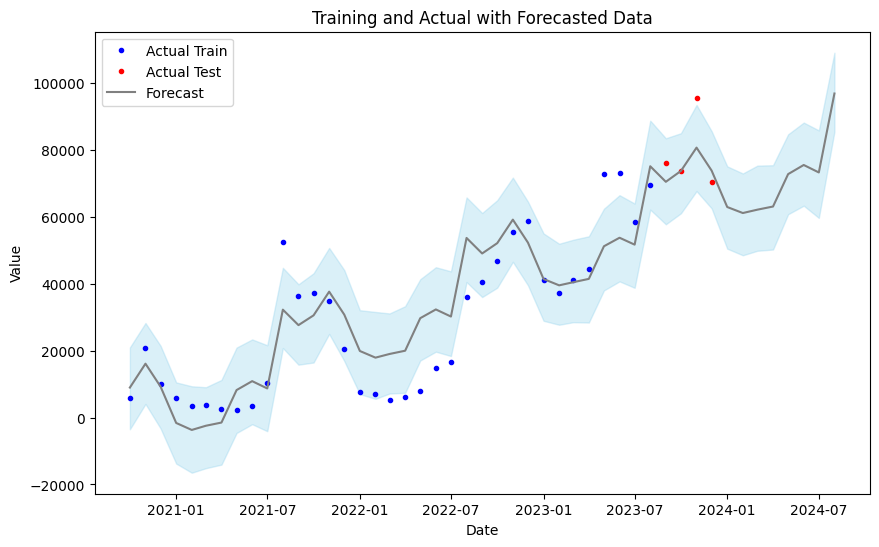

In [26]:
# show results
fig_1 = plt.figure(figsize=(10, 6))
plt.figure(figsize=(10, 6))
plt.plot(train["ds"], train["y"], '.', label='Actual Train', color = 'blue')
plt.plot(test["ds"], test["y"], '.', label='Actual Test', color = 'red')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='grey')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Training and Actual with Forecasted Data')
plt.legend()
plt.show()

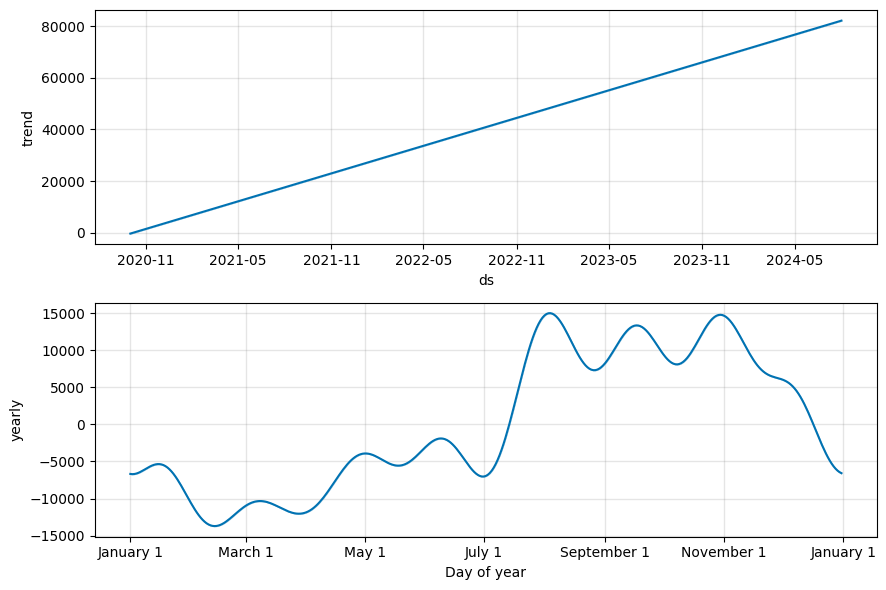

In [20]:
fig_2 = model.plot_components(forecast, plot_cap=20)